In [2]:
from abc import ABCMeta, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
%matplotlib inline

import statsmodels.api as sm
import scipy.stats as stats
from scipy.special import gamma
from scipy.stats import weibull_min, norm, t
from scipy.linalg import expm
from progressbar import ProgressBar

# Cholesky Decomposition

# Normal Generation Methods

In [6]:
# code from hw1
class BaseRNG(object):
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def draw(self, n=1):
        raise NotImplementedError
    
    def marginal_plot(self, ax, n_sample, bin_width, 
                      truncate=(-np.inf, np.inf), 
                      label='_nolegend_', which=None):
        if which is None:
            # univariate rng
            sample = self.draw(n_sample)
        else:
            # multivariate rng
            sample = self.draw(n_sample)[:,which]
        lb, ub = truncate
        bins = np.arange(max(min(sample), lb), (
            min(max(sample), ub)+bin_width), bin_width)
        ax.hist(sample, bins, normed=1, 
                alpha=0.3, color="grey", label=label)
        return ax, sample

    
class ProbIntegralGenerator(BaseRNG):
    
    def __init__(self, inv_cdf):
        self.inv_cdf = inv_cdf
        
    def draw(self, n=1):
        if n==1: return self.inv_cdf(np.random.uniform())
        u = np.random.uniform(size=n)
        return np.array([self.inv_cdf(p) for p in u])

    
class RejectionGenerator(BaseRNG):
    
    def __init__(self, inducing_rng, rej_func):
        self.inducing_rng = inducing_rng
        self.rej_func = rej_func
        
    def draw(self, n):
        container, i = np.zeros(n), 0
        while i < n:
            y = self.inducing_rng.draw()
            u = np.random.uniform()
            if u <= self.rej_func(y):
                container[i] = y
                i += 1
        if n == 1: return container[0]
        return container

    
class GoldmanSachesMixture(BaseRNG):
        
    def draw(self, n):
        u = np.random.uniform(size=n)
        z = np.random.normal(size=n)
        z[u<=0.82] *= 0.6
        z[u>0.82] *= 1.98
        return z

In [7]:
# inverse cdfs
def laplace_inv(b):
    return lambda u: np.random.choice([1,-1])*b*np.log(u)

def generalized_lambda_inv(l1, l2, l3, l4):
    return lambda u: l1 + (1/l2)*(u**l3 - (1-u)**l4)

# rejection threshold function (g(x)'s)
def laplace_induced_normal_rej(c):
    return lambda x: (1/c)*np.sqrt(2*np.e/np.pi)*np.exp(
        -0.5*(x-np.sign(x))**2)

## Rejection Method

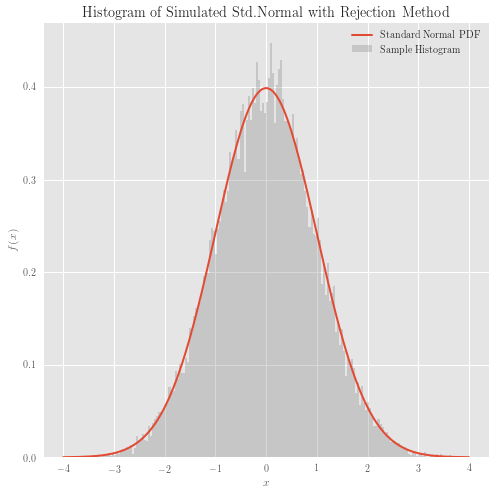

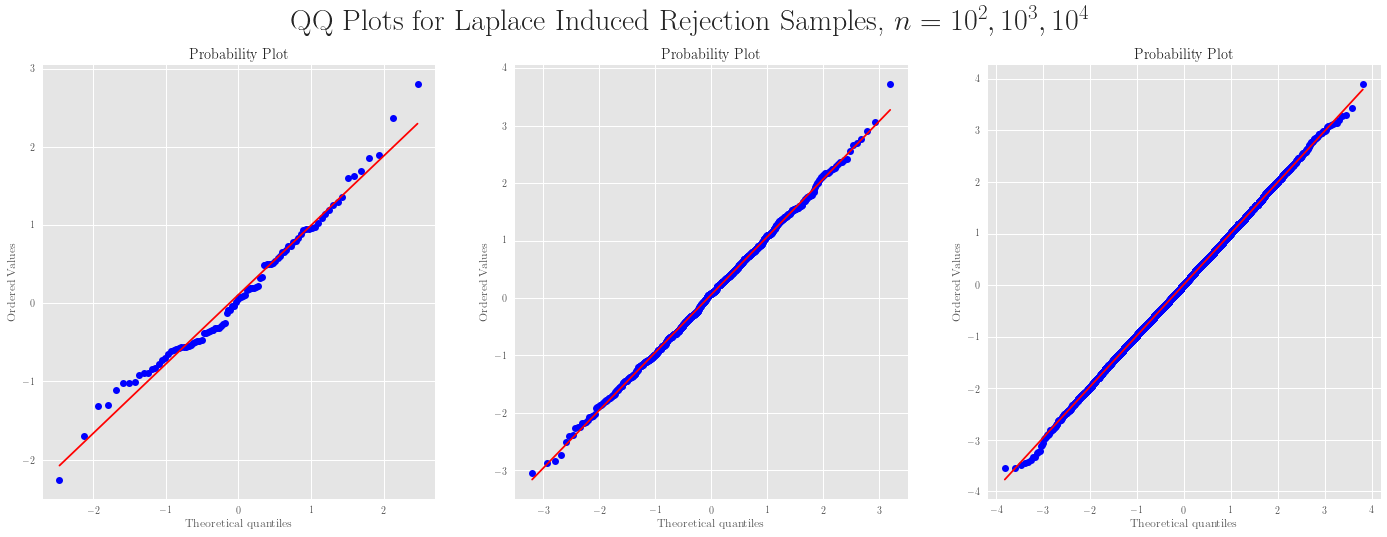

In [8]:
# rejection sampler
laplace1_sampler = ProbIntegralGenerator(laplace_inv(1))
std_normal_rejection_sampler = RejectionGenerator(
    inducing_rng=laplace1_sampler,
    rej_func=laplace_induced_normal_rej(c=np.sqrt(2*np.e/np.pi))
)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax, sample = std_normal_rejection_sampler.marginal_plot(
    ax, 20000, 0.04, label='Sample Histogram')
x = np.linspace(-4, 4, 200)
ax.plot(x, norm.pdf(x), linewidth=2, 
        label='Standard Normal PDF')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_title('Histogram of Simulated Std.Normal with Rejection Method')
ax.legend()

f, axes = plt.subplots(1,3,figsize=(24, 8))
for j in range(3):
    normal_sample = std_normal_rejection_sampler.draw(10**(j+2))
    qq = stats.probplot(
        normal_sample, dist="norm", plot=axes[j])
_ = plt.suptitle(r'QQ Plots for Laplace Induced Rejection Samples,'
                 +r' $n=10^2, 10^3, 10^4$', size=30)

## Generalized Lambda Distribution

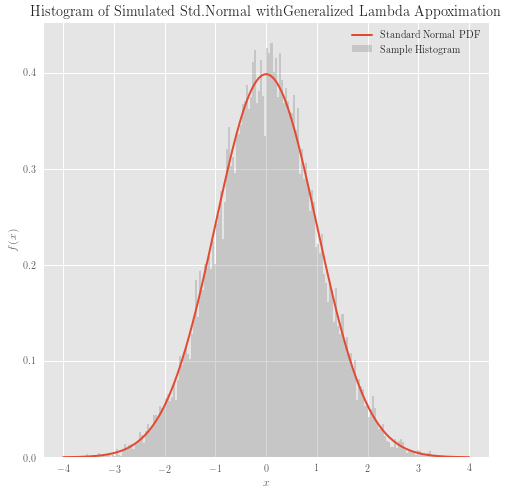

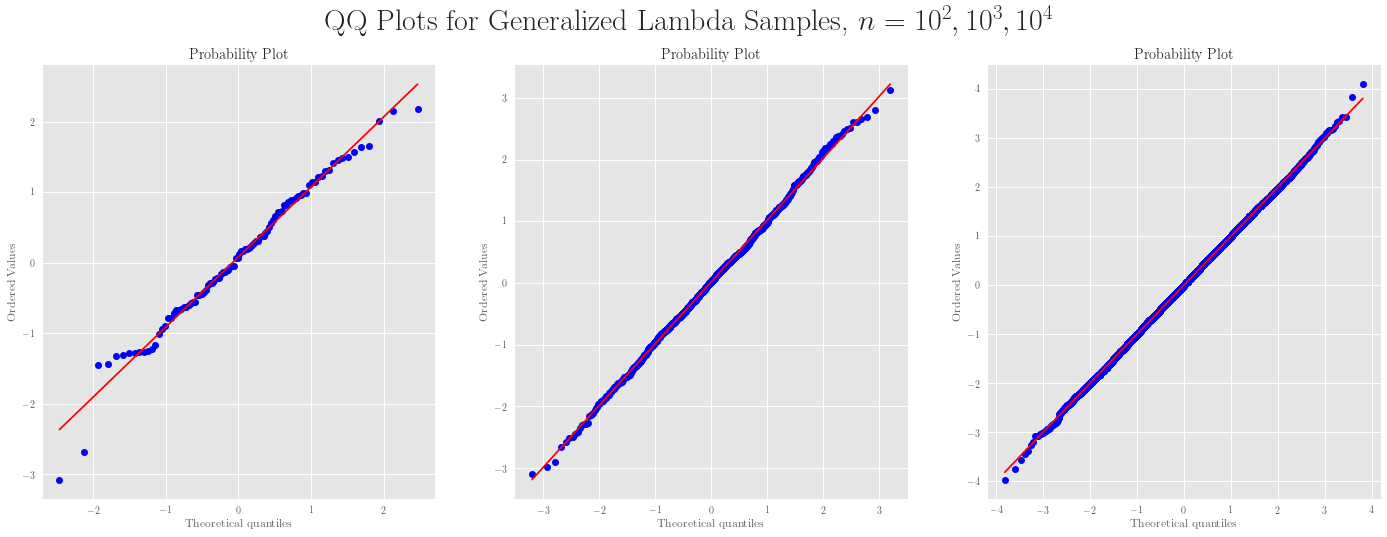

In [10]:
# generalized lambda approximation sampler
gen_lambda_approx_sampler = ProbIntegralGenerator(
    generalized_lambda_inv(0, 0.1975, 0.1349, 0.1349)
)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax, sample = gen_lambda_approx_sampler.marginal_plot(
    ax, 20000, 0.04, label='Sample Histogram')
x = np.linspace(-4, 4, 200)
ax.plot(x, norm.pdf(x), linewidth=2, 
        label='Standard Normal PDF')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_title('Histogram of Simulated Std.Normal with' + 
             'Generalized Lambda Appoximation')
ax.legend()

f, axes = plt.subplots(1,3,figsize=(24, 8))
for j in range(3):
    normal_sample = gen_lambda_approx_sampler.draw(10**(j+2))
    qq = stats.probplot(
        normal_sample, dist="norm", plot=axes[j])
_ = plt.suptitle(r'QQ Plots for Generalized Lambda Samples,'
             +r' $n=10^2, 10^3, 10^4$', size=30)

## "Goldman Sachs Weighted Normal"

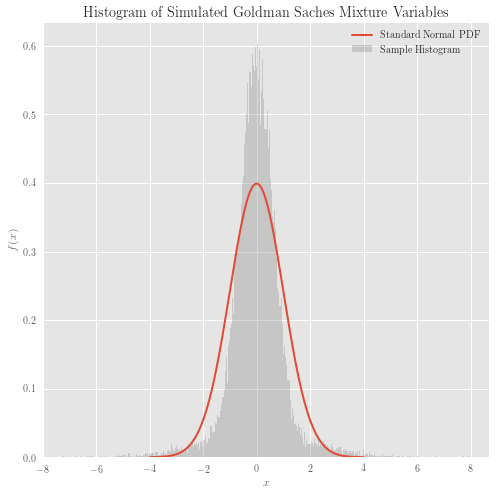

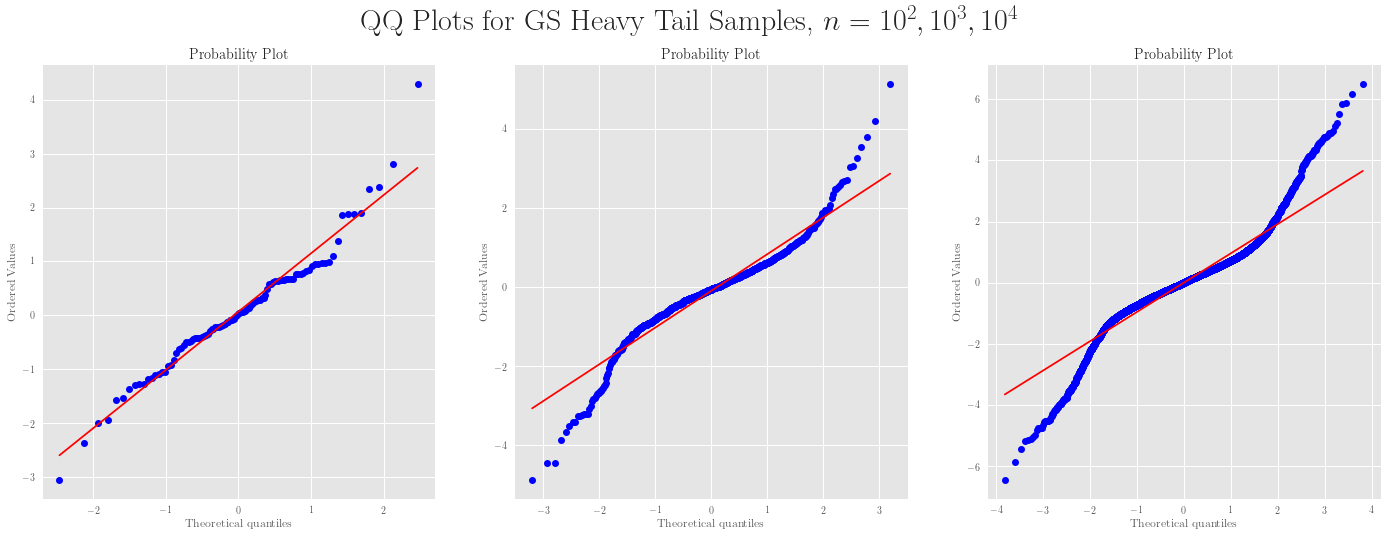

In [11]:
# goldman heavy tail sampler
gs_heavy_tail_sampler = GoldmanSachesMixture()
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax, sample = gs_heavy_tail_sampler.marginal_plot(
    ax, 20000, 0.04, label='Sample Histogram')
x = np.linspace(-4, 4, 200)
ax.plot(x, norm.pdf(x), linewidth=2, 
        label='Standard Normal PDF')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_title('Histogram of Simulated ' + 
             'Goldman Saches Mixture Variables')
ax.legend()

f, axes = plt.subplots(1,3,figsize=(24, 8))
for j in range(3):
    normal_sample = gs_heavy_tail_sampler.draw(10**(j+2))
    qq = stats.probplot(
        normal_sample, dist="norm", plot=axes[j])
_ = plt.suptitle(r'QQ Plots for GS Heavy Tail Samples,'
                 +r' $n=10^2, 10^3, 10^4$', size=30)

# Bivariate Copula

In [57]:
class BaseCopula(BaseRNG):
    __metaclass__ = ABCMeta
    
    def reset_cov(self, cov_matrix):
        assert len(cov_matrix) == self.d
        self.cov = cov_matrix
        self.std = np.sqrt(np.diag(self.cov))
        self.A = np.linalg.cholesky(self.cov).T
            
    def bivariate_plot(self, n_sample, d1=0, d2=1):
        X = self.draw(n_sample)
        g = sns.jointplot(X[:,d1], X[:,d2], kind="reg")
        return g
    

class GaussianCopula(BaseCopula):
    
    def __init__(self, cov_matrix, marginal_inv_cdfs=None):
        self.inv_cdfs = marginal_inv_cdfs
        self.cov = cov_matrix
        self.std = np.sqrt(np.diag(self.cov))
        self.d = len(self.cov)
        self.A = np.linalg.cholesky(self.cov).T 
        
    def draw(self, n):
        Z = np.random.normal(size=(n, self.d))
        Y = Z.dot(self.A)
        if not self.inv_cdfs: return Y
        U = norm.cdf(Y/self.std)
        return np.apply_along_axis(self.inv_cdfs, 1, U)

    
class StudentTCopula(GaussianCopula):
    
    def __init__(self, df, cov_matrix, marginal_inv_cdfs=None):
        super(StudentTCopula, self).__init__(
            cov_matrix, marginal_inv_cdfs)
        self.df = df
        
    def draw(self, n):
        Z = np.random.normal(size=(n, self.d))
        Y = Z.dot(self.A)
        S = np.random.chisquare(df=self.df, size=n)
        T = Y*np.sqrt(self.df/S).reshape(n,1)
        if not self.inv_cdfs: return T
        U = t.cdf(T/self.std, df=self.df)
        return np.apply_along_axis(self.inv_cdfs, 1, U)
    

In [17]:
# inverse marginal cdfs
def exponential_marginal_inv(b_vec):
    return lambda u: np.array(
        [b*np.log(u[i]) for i,b in enumerate(b_vec)])

## Bivariate Normal

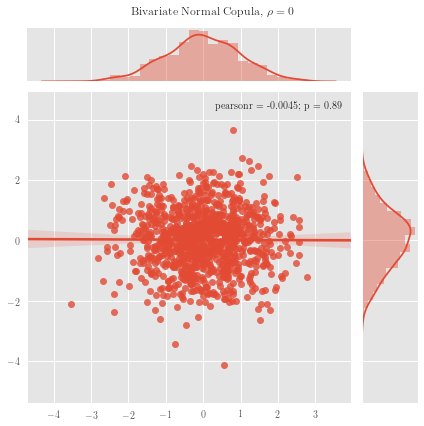

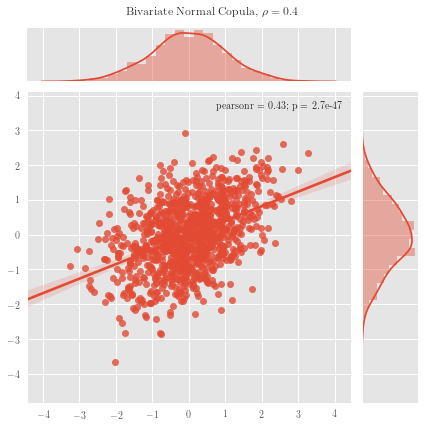

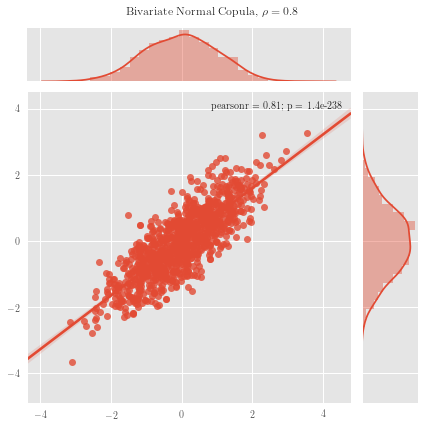

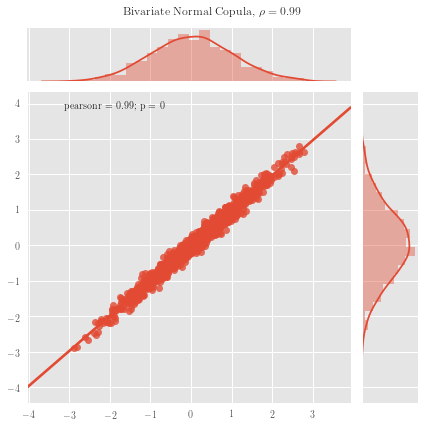

In [48]:
gs_copula_sampler = GaussianCopula(
    np.array([[1,0], [0,1]])
)
for rho in [0, 0.4, 0.8, 0.99]:
    gs_copula_sampler.reset_cov(
        np.array([[1,rho], [rho,1]])
    )
    g = gs_copula_sampler.bivariate_plot(1000)
    plt.subplots_adjust(top=0.93)
    g.fig.suptitle('Bivariate Normal Copula, '
                   +r'$\rho={}$'.format(rho))

## Student T(5) Copula

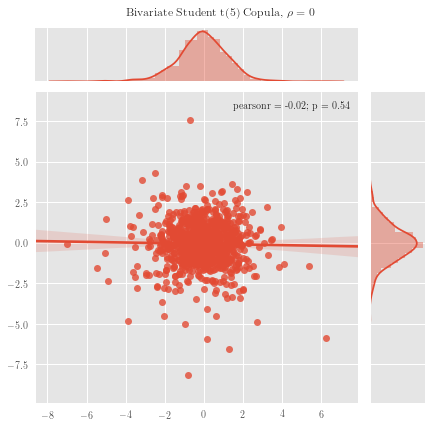

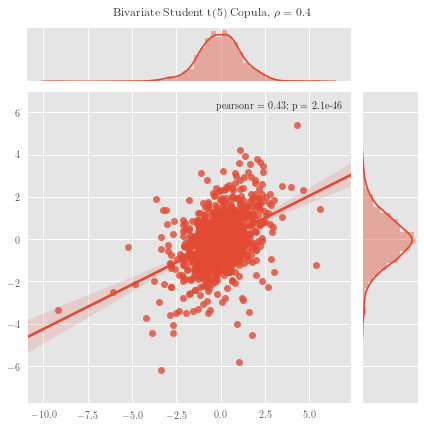

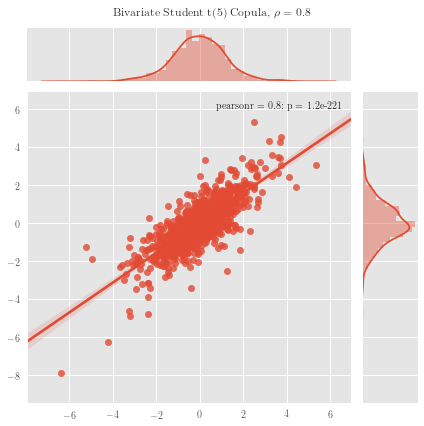

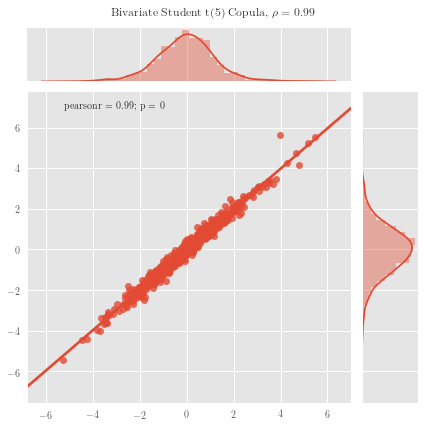

In [50]:
t_copula_sampler = StudentTCopula(
    df=5,
    cov_matrix=np.array([[1,0], [0,1]])
)
for rho in [0, 0.4, 0.8, 0.99]:
    t_copula_sampler.reset_cov(
        np.array([[1,rho], [rho,1]])
    )
    g = t_copula_sampler.bivariate_plot(1000)
    plt.subplots_adjust(top=0.93)
    g.fig.suptitle('Bivariate Student t(5) Copula, '
                   +r'$\rho={}$'.format(rho))

## Gaussian Copula, Exponential(1) Marginal

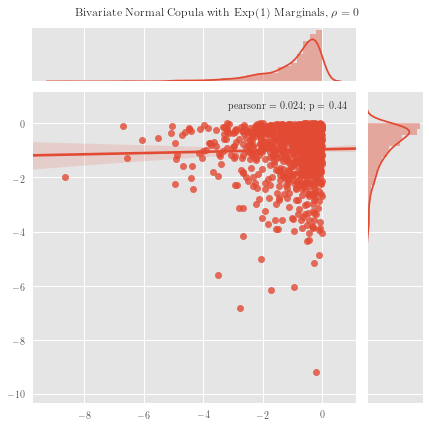

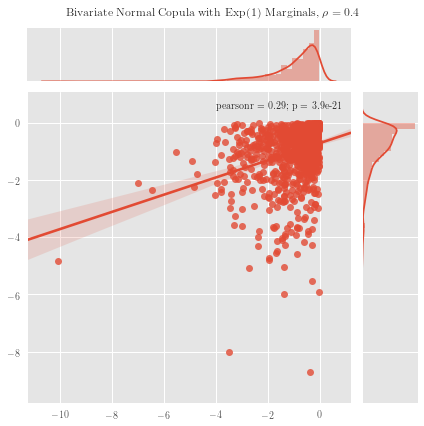

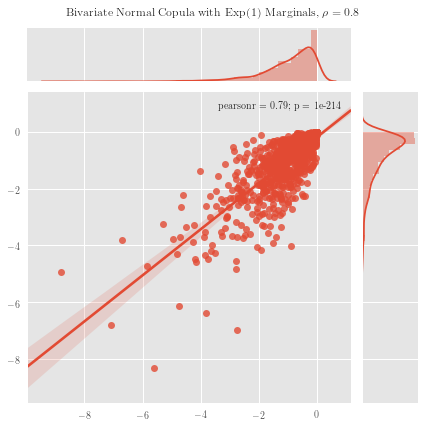

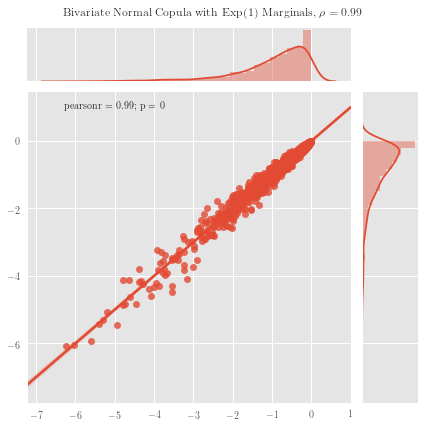

In [72]:
gsexp_copula_sampler = GaussianCopula(
    cov_matrix=np.array([[1,0], [0,1]]),
    marginal_inv_cdfs=exponential_marginal_inv([1,1])
)
for rho in [0, 0.4, 0.8, 0.99]:
    gsexp_copula_sampler.reset_cov(
        np.array([[1,rho], [rho,1]])
    )
    g = gsexp_copula_sampler.bivariate_plot(1000)
    plt.subplots_adjust(top=0.93)
    g.fig.suptitle('Bivariate Normal Copula with Exp(1) Marginals, '
                   +r'$\rho={}$'.format(rho))

## Student T(5) Copula, Exponential(1) Marginal

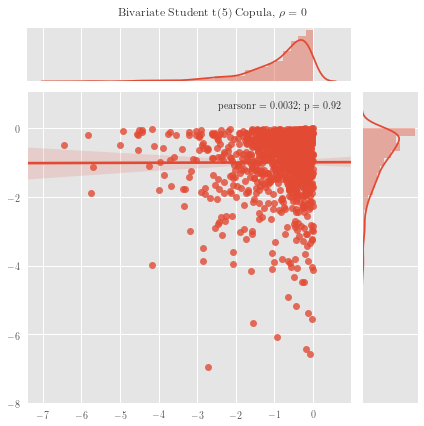

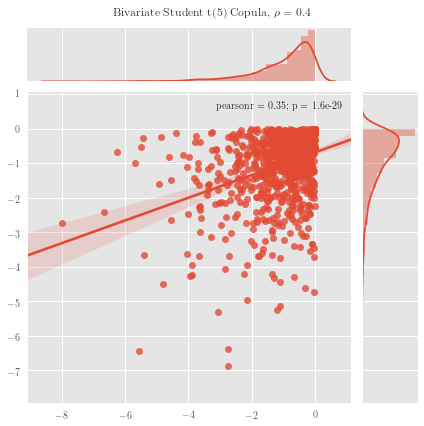

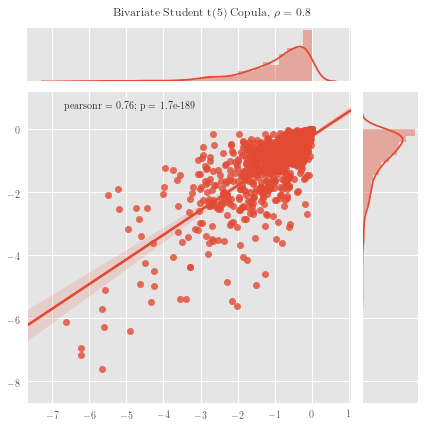

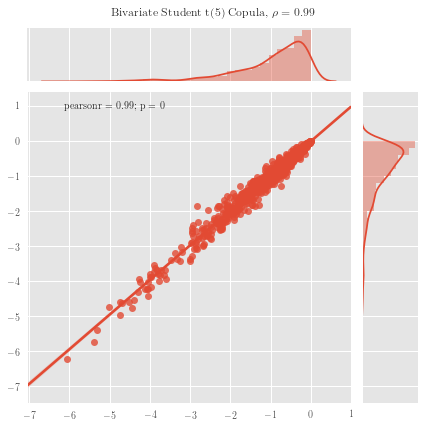

In [71]:
t_copula_sampler = StudentTCopula(
    df=5,
    cov_matrix=np.array([[1,0], [0,1]]),
    marginal_inv_cdfs=exponential_marginal_inv([1,1])
)
for rho in [0, 0.4, 0.8, 0.99]:
    t_copula_sampler.reset_cov(
        np.array([[1,rho], [rho,1]])
    )
    g = t_copula_sampler.bivariate_plot(1000)
    plt.subplots_adjust(top=0.93)
    g.fig.suptitle('Bivariate Student t(5) Copula, '
                   +r'$\rho={}$'.format(rho))

## Student T(1) Copula, Exponential(1) Marginal

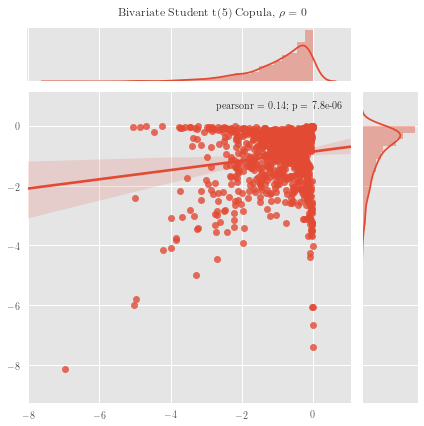

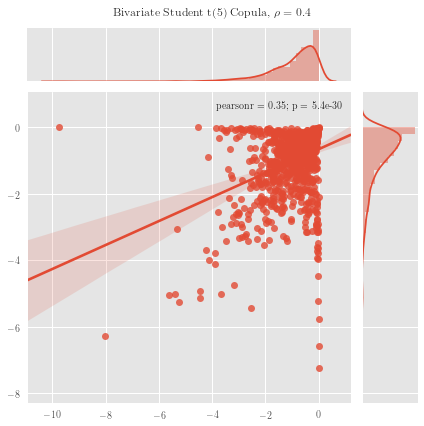

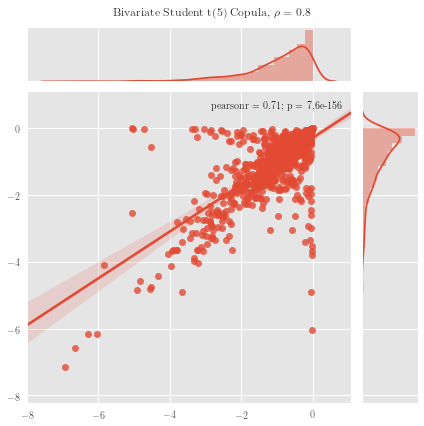

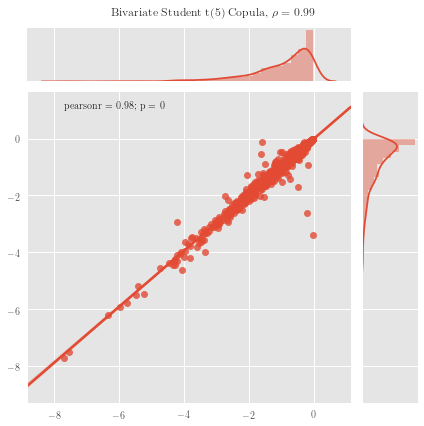

In [73]:
t_copula_sampler = StudentTCopula(
    df=1,
    cov_matrix=np.array([[1,0], [0,1]]),
    marginal_inv_cdfs=exponential_marginal_inv([1,1])
)
for rho in [0, 0.4, 0.8, 0.99]:
    t_copula_sampler.reset_cov(
        np.array([[1,rho], [rho,1]])
    )
    g = t_copula_sampler.bivariate_plot(1000)
    plt.subplots_adjust(top=0.93)
    g.fig.suptitle('Bivariate Student t(5) Copula, '
                   +r'$\rho={}$'.format(rho))

# T Variables with Rejection Method

In [5]:
def t_scaler(n):
    if n > 340: return np.sqrt(2*np.pi/np.e)
    return (gamma(n/2+0.5)/(np.sqrt(n/np.pi)*gamma(n/2))) * (
        2/((1+1/n)**(n/2+0.5)))

def cauchy_inv(x0, gamma):
    return lambda u: gamma*np.tan(np.pi*u-np.pi/2)+x0

def cauchy_induced_t_rej(df):
    C = t_scaler(df)
    return lambda x: (1/C)*t.pdf(x, df)*np.pi*(1+x**2)

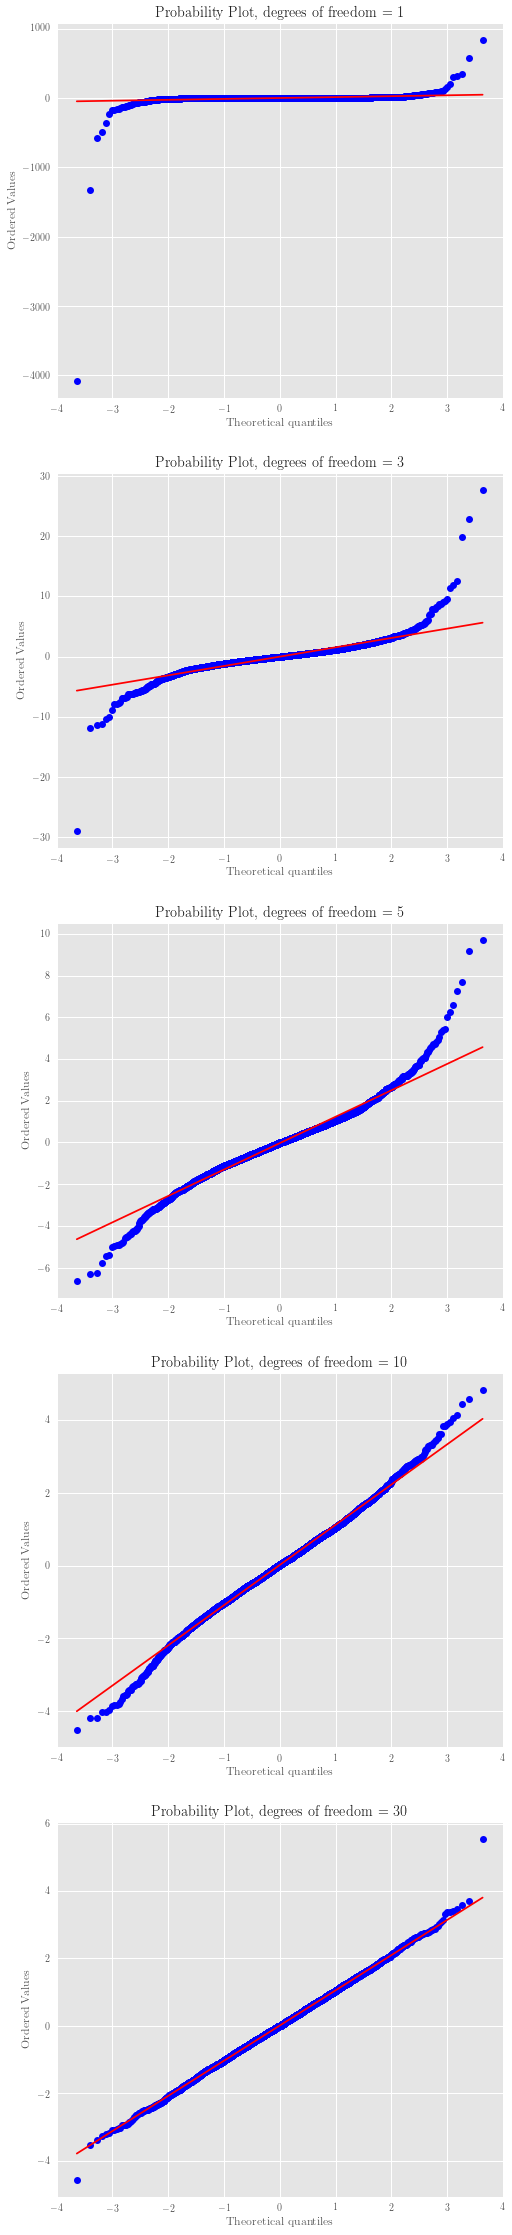

In [9]:
f, axes = plt.subplots(5,1,figsize=(8, 40))
for i, df in enumerate([1, 3, 5, 10, 30]):
    cauchy_sampler = ProbIntegralGenerator(cauchy_inv(0,1))
    t_rejection_sampler = RejectionGenerator(
        inducing_rng=cauchy_sampler,
        rej_func=cauchy_induced_t_rej(df=df)
    )
    t_sample = t_rejection_sampler.draw(5000)
    qq = stats.probplot(
        t_sample, dist="norm", plot=axes[i])
    axes[i].set_title(
        'Probability Plot, degrees of freedom = {}'.format(df))